# Student Performance Predictor



# **Libraries**

In [ ]:
import os
import sys
import json
import datetime
import csv
import io
import hashlib
import secrets
import re
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import torch

from flask import Flask, request, jsonify, send_from_directory, Response, redirect, url_for
import jwt
from functools import wraps
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Load dataset**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/student_project/StudentPerformanceFactors.csv')
df.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


# **Data Proprocess**

In [4]:
df.isnull().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [5]:
df.dropna(axis=1, inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isnull().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [8]:
target = "Exam_Score"
if target not in df.columns:
    print("ERROR: Target column 'Exam_Score' not found in dataset")
    sys.exit(1)

X_df = df.drop(columns=[target])
y = df[target]

cat_cols = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Detected numeric columns:", num_cols)
print("Detected categorical columns:", cat_cols)

Detected numeric columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
Detected categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Gender']


In [19]:
from sklearn import __version__ as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
from pathlib import Path

PREPROCESSOR_PATH = Path("preprocessor.pkl")

_major = int(skl.split(".")[0])
_minor = int(skl.split(".")[1]) if len(skl.split(".")) > 1 else 0

if _major >= 1 and _minor >= 2:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", ohe, cat_cols)
])

if PREPROCESSOR_PATH.exists():
    preprocessor = joblib.load(PREPROCESSOR_PATH)
    print("Loaded preprocessor from cache")
else:
    preprocessor = preprocessor.fit(X_df)
    joblib.dump(preprocessor, PREPROCESSOR_PATH)
    print("Fitted and saved preprocessor")


Fitted and saved preprocessor


# **Dataset visualization**

*  Correlation matrix
*  Target hist
*  Scatter matrix


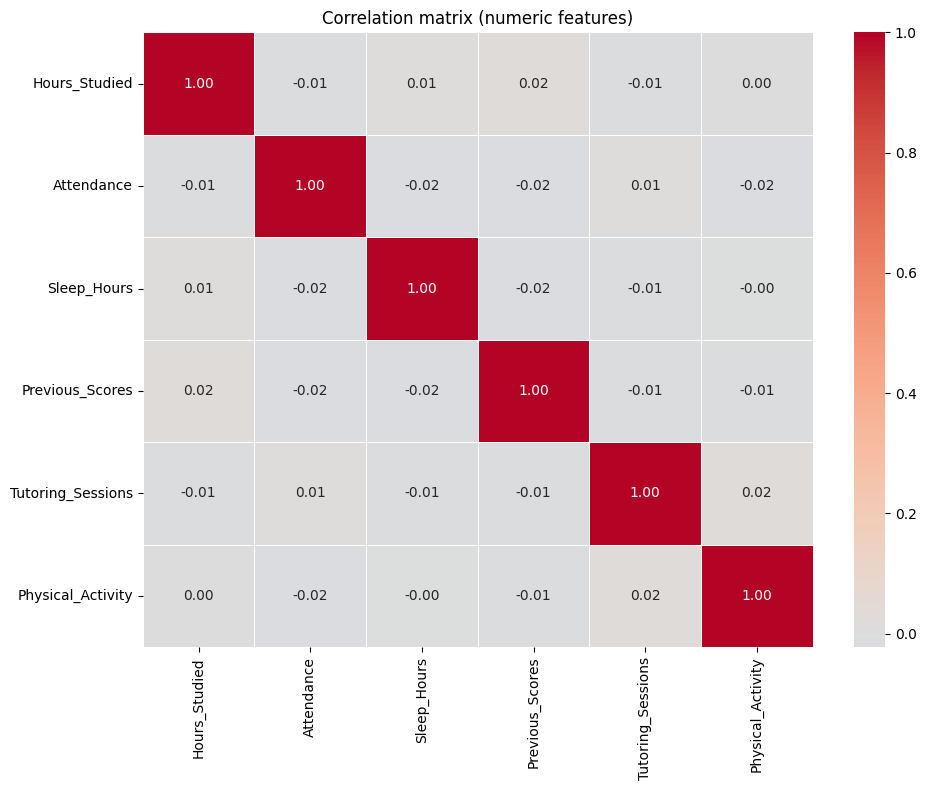

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()


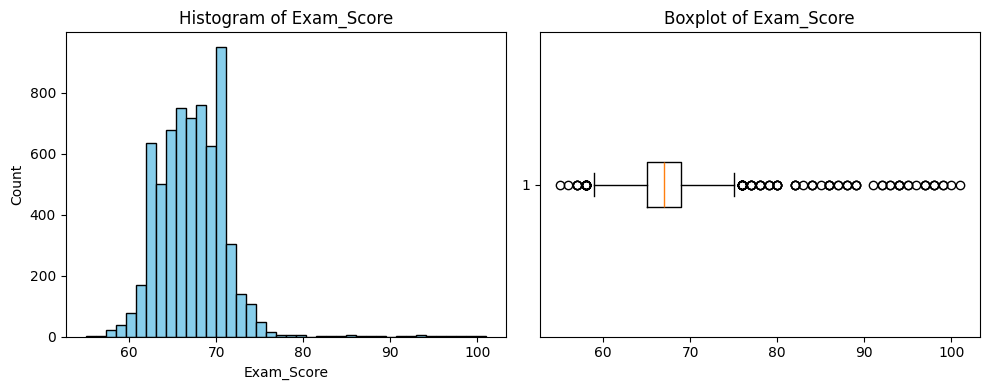

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df[target].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title(f"Histogram of {target}")
plt.xlabel(target); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.boxplot(df[target].dropna(), vert=False)
plt.title(f"Boxplot of {target}")

plt.tight_layout()
plt.show()


Top features correlated with target: ['Attendance', 'Hours_Studied', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


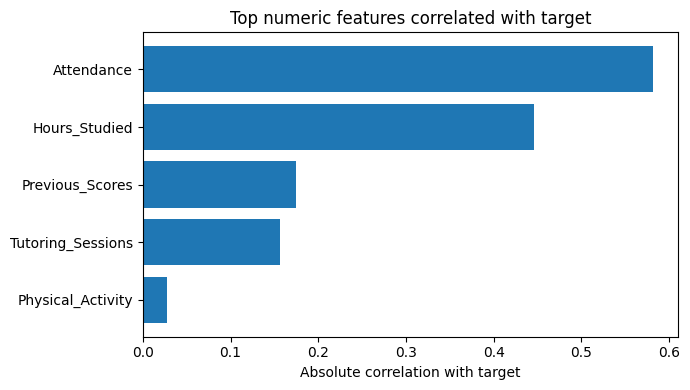

In [12]:
import matplotlib.pyplot as plt
import numpy as np
corr_with_target = df[num_cols + [target]].corr()[target].abs().sort_values(ascending=False)
top_feats = list(corr_with_target.index[1:6])
print("Top features correlated with target:", top_feats)

vals = corr_with_target[top_feats].values
plt.figure(figsize=(7,4))
plt.barh(top_feats[::-1], vals[::-1], color='C0')
plt.xlabel("Absolute correlation with target")
plt.title("Top numeric features correlated with target")
plt.tight_layout()
plt.show()


Pairplot sampled 500 rows (from 6607)


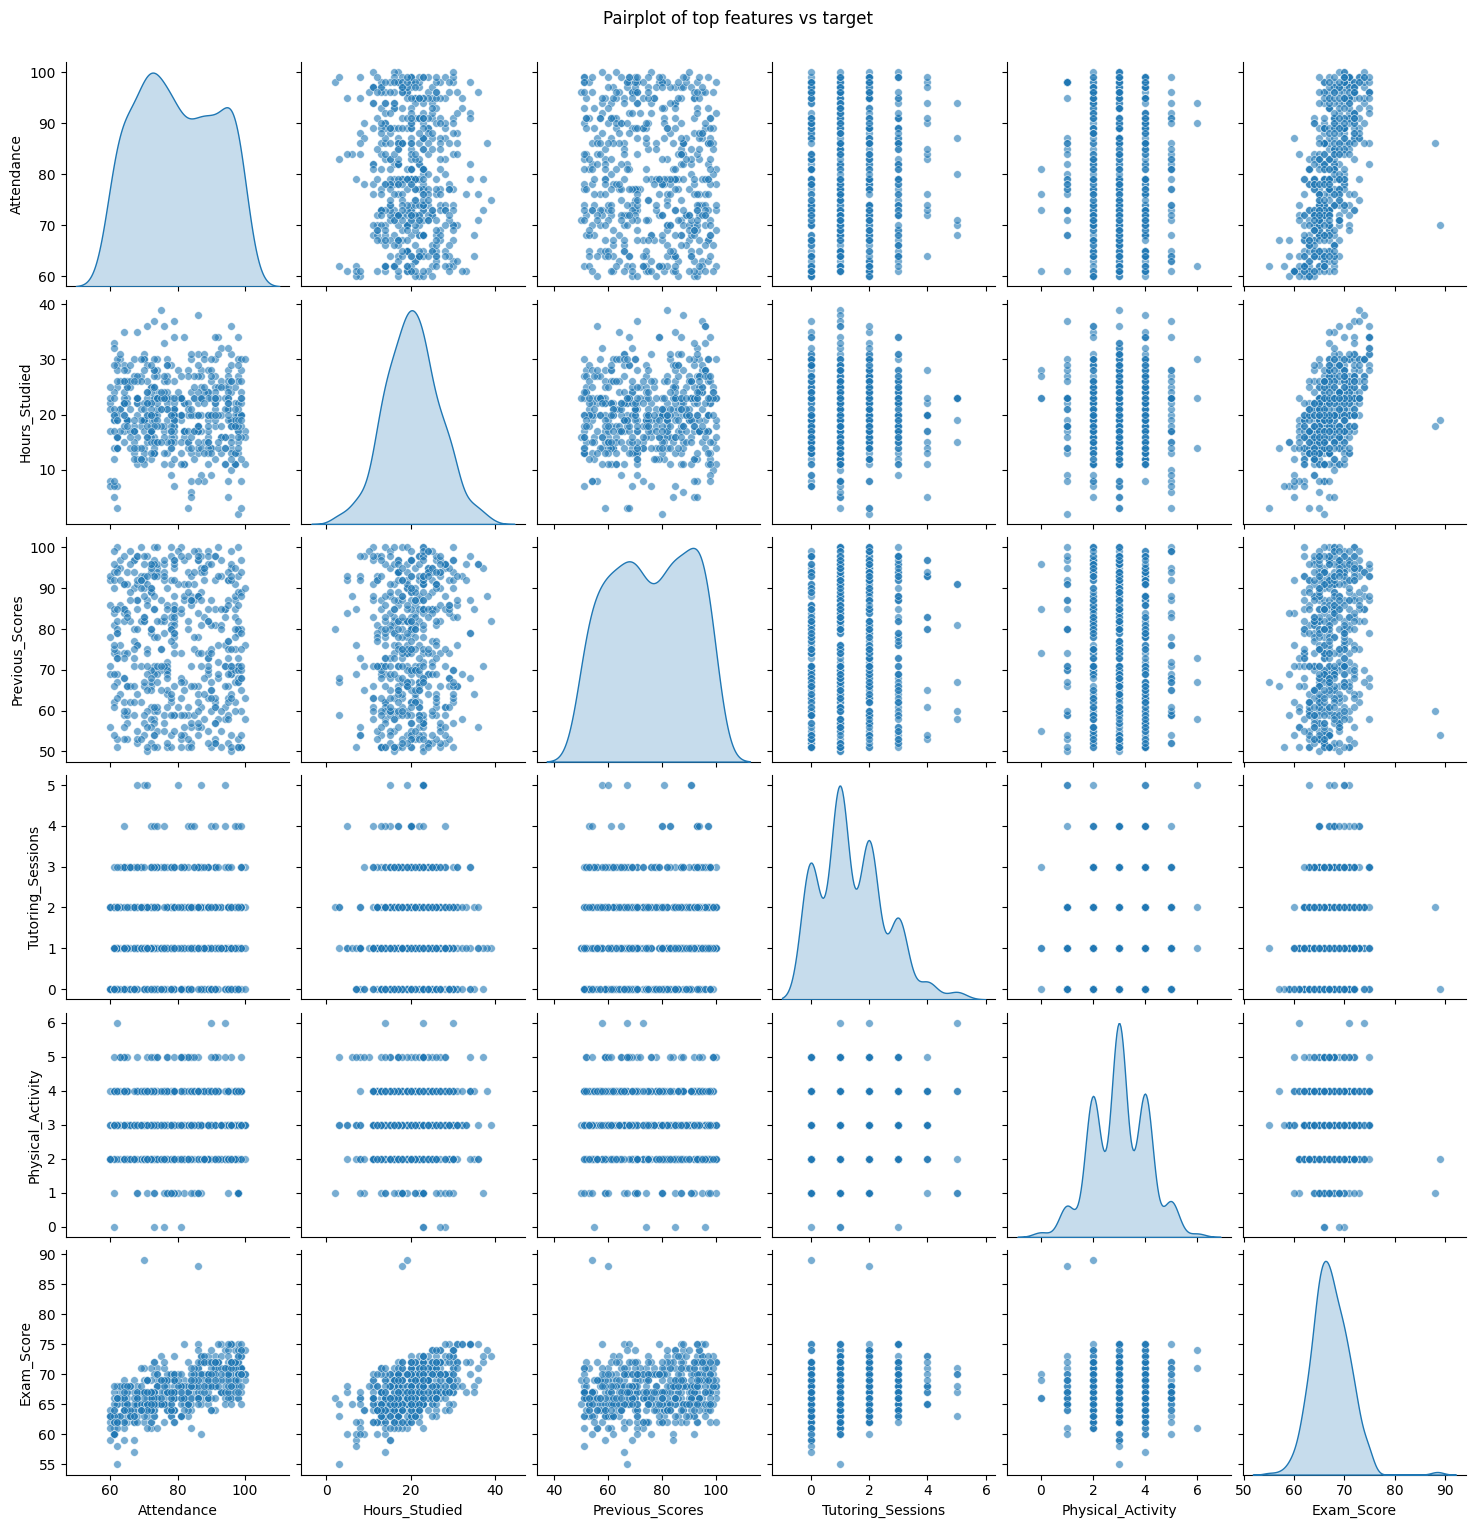

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

pair_cols = top_feats + [target]
pair_df = df[pair_cols].dropna()
sample_n = min(500, len(pair_df))
if len(pair_df) > sample_n:
    pair_df = pair_df.sample(sample_n, random_state=42)
    print(f"Pairplot sampled {sample_n} rows (from {len(df)})")

sns.pairplot(pair_df, diag_kind='kde', plot_kws={'s':30, 'alpha':0.6})
plt.suptitle("Pairplot of top features vs target", y=1.02)
plt.show()


In [14]:
X_df = df.drop(columns=[target])
y = df[target]

# **Classical Models**

# **Splitting Data**

In [21]:
X_processed = preprocessor.transform(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# **Feature Scaling for SVM**

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset shape after cleaning:", df.shape)

Dataset shape after cleaning: (6607, 17)


# **Linear Regression**

In [23]:
model_performance = {}

print("Training classical models (Linear Regression only)...")
lr = LinearRegression().fit(X_train, y_train)

lr_pred = lr.predict(X_test)

model_performance['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, lr_pred),
    'MSE': mean_squared_error(y_test, lr_pred),
    'R2': r2_score(y_test, lr_pred)
}

print("Classical Models Performance:")
for model_name, metrics in model_performance.items():
    print(f"{model_name}: MAE={metrics['MAE']:.3f}, R²={metrics['R2']:.3f}")

Training classical models (Linear Regression only)...
Classical Models Performance:
Linear Regression: MAE=0.674, R²=0.745


# **Comparison of classical**

In [24]:
print(f"Linear Regression - R² Score : {r2_score(y_test, lr_pred)}")


Linear Regression - R² Score : 0.7446756213059302


# **NN Model**

In [25]:
input_dim = X_train.shape[1]

def build_nn(input_dim):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.20),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),

        layers.Dense(32, activation='relu'),

        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)

    m.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return m

In [ ]:
print("Setting up Neural Network...")

from pathlib import Path

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = ARTIFACTS_DIR / "best_model.keras"


if MODEL_PATH.exists():
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded model from cache:", MODEL_PATH)

else:
    model = build_nn(input_dim)

    es = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    rlr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=5,
        factor=0.5
    )

    cp = callbacks.ModelCheckpoint(
        filepath=str(MODEL_PATH),
        save_best_only=True
    )

    print("Training Neural Network...")

    history = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=250,
        batch_size=64,
        callbacks=[es, rlr, cp],
        verbose=1
    )

    with open(ARTIFACTS_DIR / "training_history.json", "w") as f:
        json.dump(history.history, f)

    print("Model trained and saved to:", MODEL_PATH)


nn_preds = model.predict(X_test).flatten()

model_performance['Neural Network'] = {
    'MAE': mean_absolute_error(y_test, nn_preds),
    'MSE': mean_squared_error(y_test, nn_preds),
    'R2': r2_score(y_test, nn_preds)
}

print("Neural Network Performance:")
print(f"MAE: {model_performance['Neural Network']['MAE']:.3f}")
print(f"R²: {model_performance['Neural Network']['R2']:.3f}")

Setting up Neural Network...
Training Neural Network...
Epoch 1/250
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 3995.9407 - root_mean_squared_error: 63.1732 - val_loss: 2496.1208 - val_root_mean_squared_error: 49.9612 - learning_rate: 0.0015
Epoch 2/250
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1141.7909 - root_mean_squared_error: 33.2675 - val_loss: 149.7994 - val_root_mean_squared_error: 12.2393 - learning_rate: 0.0015
Epoch 3/250
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.1286 - root_mean_squared_error: 8.1667 - val_loss: 17.2017 - val_root_mean_squared_error: 4.1475 - learning_rate: 0.0015
Epoch 4/250
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.6634 - root_mean_squared_error: 6.1256 - val_loss: 16.0501 - val_root_mean_squared_error: 4.0063 - learning_rate: 0.0015
Epoch 5/250
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33.0209 - root_mean_squared_error: 5.7439 - val_loss: 13.3015 - val_root_mean_squared_error: 3.6471 - learning_rate: 0.0015
Epoch 6/250
71/7

In [27]:
import numpy as np, pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

OUT_DIR = "/content/plots"
os.makedirs(OUT_DIR, exist_ok=True)

model_dict = {}
if 'lr' in globals(): model_dict['Linear Regression'] = lr
if 'model' in globals(): model_dict['Neural Network'] = model

def predict_model(m, X):
    p = m.predict(X)
    return np.array(p).reshape(-1)

metrics = []; predictions = {}; abs_errors = {}

for name, m in model_dict.items():
    y_pred = predict_model(m, X_test)
    predictions[name] = y_pred

    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    metrics.append({"model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    abs_errors[name] = np.abs(y_test - y_pred)

metrics_df = pd.DataFrame(metrics).set_index('model')[['R2','RMSE','MAE']]
display(metrics_df.round(4))


,R2,RMSE,MAE
model,,,
Linear Regression,0.7447,1.8997,0.6738


# **visualize & comparison**

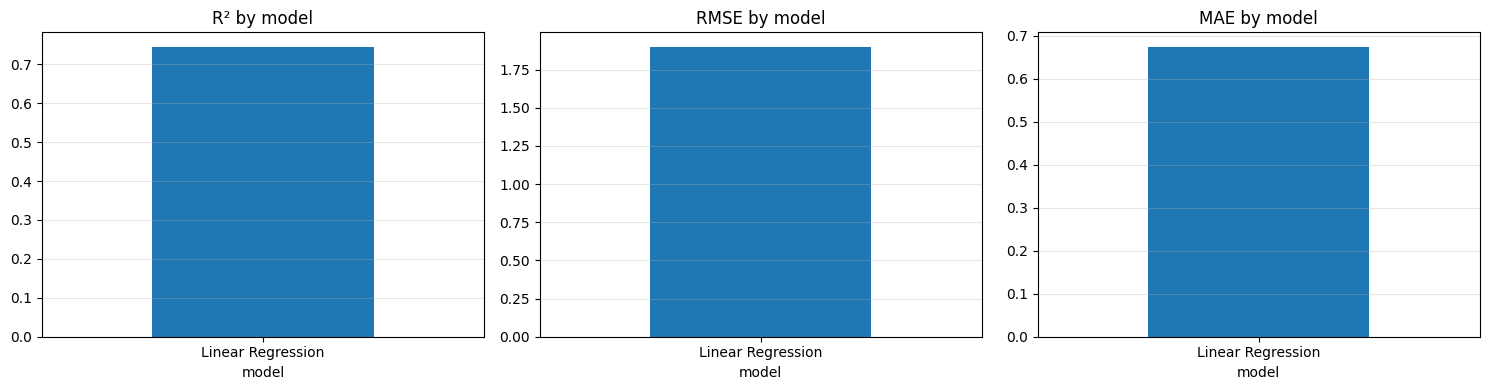

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,4))
metrics_df['R2'].plot(kind='bar', ax=ax[0], rot=0, title='R² by model')
metrics_df['RMSE'].plot(kind='bar', ax=ax[1], rot=0, title='RMSE by model')
metrics_df['MAE'].plot(kind='bar', ax=ax[2], rot=0, title='MAE by model')
for a in ax: a.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR+"/metrics_comparison.png", dpi=150)
plt.show()

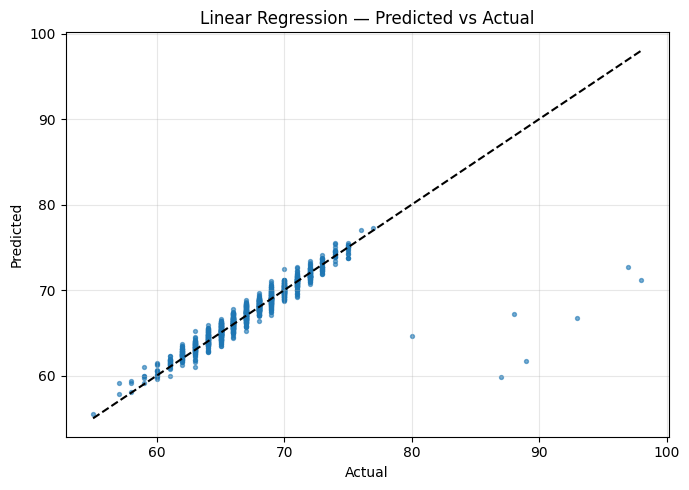

In [29]:
fig, axes = plt.subplots(len(predictions),1, figsize=(7,5*len(predictions)))
if len(predictions)==1:
    axes=[axes]
for ax, (name, preds) in zip(axes, predictions.items()):
    ax.scatter(y_test, preds, s=8, alpha=0.6)
    mn, mx = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
    ax.plot([mn,mx],[mn,mx], color='k', linestyle='--')
    ax.set_title(f"{name} — Predicted vs Actual")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted"); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR+"/pred_vs_actual.png", dpi=150)
plt.show()

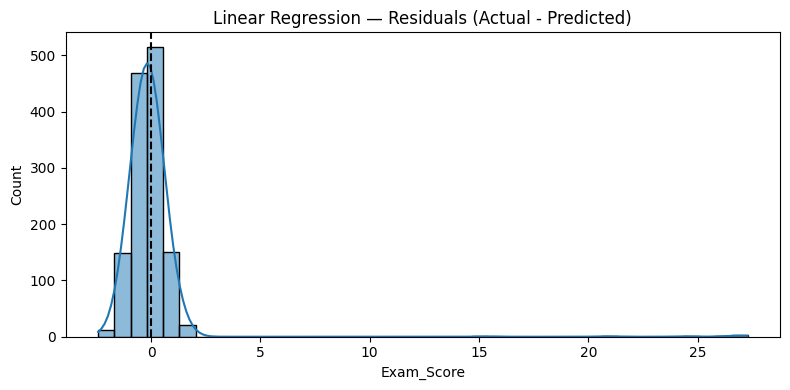

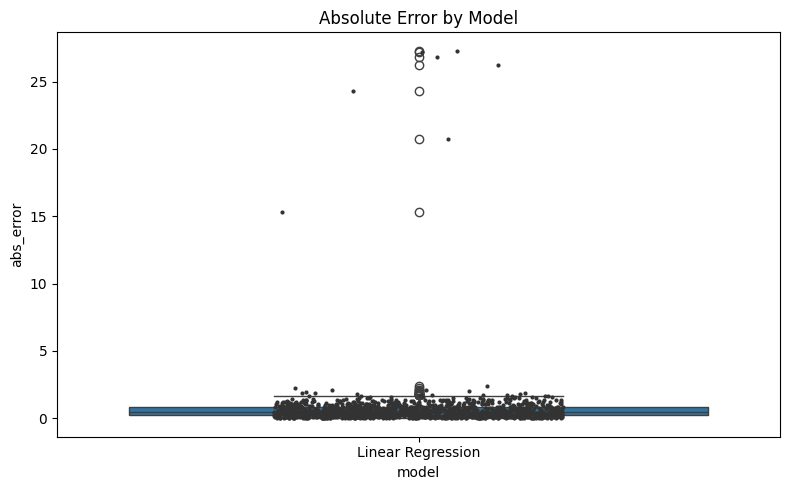

In [30]:
import seaborn as sns
fig, axes = plt.subplots(len(predictions),1, figsize=(8,4*len(predictions)))
if len(predictions)==1:
    axes=[axes]
for ax, (name, preds) in zip(axes, predictions.items()):
    resid = y_test - preds
    sns.histplot(resid, kde=True, ax=ax, bins=40)
    ax.set_title(f"{name} — Residuals (Actual - Predicted)")
    ax.axvline(0, color='k', linestyle='--')
plt.tight_layout(); plt.savefig(OUT_DIR+"/residuals_hist.png", dpi=150); plt.show()

ae_df = pd.DataFrame({k:v for k,v in abs_errors.items()})
ae_melt = ae_df.melt(var_name='model', value_name='abs_error')
plt.figure(figsize=(8,5))
sns.boxplot(x='model', y='abs_error', data=ae_melt)
sns.stripplot(x='model', y='abs_error', data=ae_melt, color='0.2', size=3, jitter=0.2)
plt.title("Absolute Error by Model")
plt.tight_layout(); plt.savefig(OUT_DIR+"/abs_error_boxplot.png", dpi=150); plt.show()

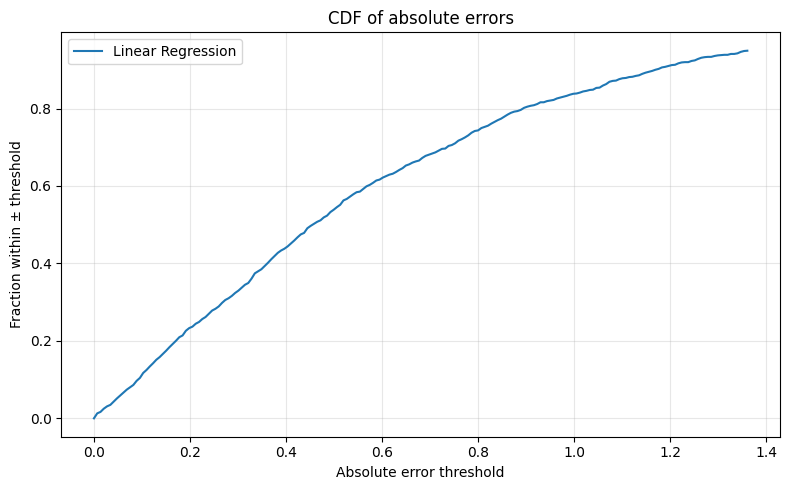

In [31]:
import numpy as np
thr = np.linspace(0, np.percentile(np.concatenate(list(abs_errors.values())),95), 200)
plt.figure(figsize=(8,5))
for name, arr in abs_errors.items():
    cdf = [(arr <= t).mean() for t in thr]
    plt.plot(thr, cdf, label=name)
plt.xlabel("Absolute error threshold"); plt.ylabel("Fraction within ± threshold")
plt.title("CDF of absolute errors"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(OUT_DIR+"/cdf_abs_error.png", dpi=150); plt.show()

In [32]:
import json
hist=None
if 'history' in globals():
    hist = history.history
else:
    hist_path = "artifacts/training_history.json"
    import os
    if os.path.exists(hist_path):
        hist = json.load(open(hist_path))
if hist:
    plt.figure(figsize=(8,4))
    plt.plot(hist.get('loss',[]), label='train_loss')
    plt.plot(hist.get('val_loss',[]), label='val_loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss (MSE)"); plt.title("NN Training Loss"); plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(OUT_DIR+"/nn_loss.png", dpi=150); plt.show()
else:
    print("No training history found (history variable or artifacts/training_history.json).")

No training history found (history variable or artifacts/training_history.json).


In [33]:
best = metrics_df['R2'].idxmax()
bm = metrics_df.loc[best].to_dict()
print(f"Best model by R²: {best}")
print(f"R²={bm['R2']:.4f}, RMSE={bm['RMSE']:.4f}, MAE={bm['MAE']:.4f}")
print("\nWhy it's best (quick checklist):")
print("- Highest R²: explains most variance")
print("- Lower RMSE/MAE: smaller average errors")
print("- Check feature importance plot above to see which features drive predictions")
print("- Check residual plots for bias/heteroscedasticity (Residuals cell)")

Best model by R²: Linear Regression
R²=0.7447, RMSE=1.8997, MAE=0.6738

Why it's best (quick checklist):
- Highest R²: explains most variance
- Lower RMSE/MAE: smaller average errors
- Check feature importance plot above to see which features drive predictions
- Check residual plots for bias/heteroscedasticity (Residuals cell)


## Download Artifacts


In [34]:
from google.colab import files

files.download("/content/drive/MyDrive/student_project/best_model.keras")
files.download("/content/drive/MyDrive/student_project/preprocessor.pkl")
files.download("/content/drive/MyDrive/student_project/training_history.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>